In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [26]:
import sys
sys.path.append('../../../')

from src.transformer_utils  import encode_labels

## 1. Chargement du jeu de donnnées

In [27]:
df = pd.read_csv('../../../data/outputs/05_merged_data.csv')

In [28]:
print(df.shape)
df.head()

(26080, 24)


,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,round,circuitId,circuit_name,constructor_name,country,constructor_is_active,nationality,driver_is_active,full_name,season_age
0,1,18,1,1,1,1,10.0,58,5690616,39,...,1,1,Australian Grand Prix,McLaren,British,1,British,1,Lewis Hamilton,23
1,2,18,2,2,5,2,8.0,58,5696094,41,...,1,1,Australian Grand Prix,BMW Sauber,German,0,German,0,Nick Heidfeld,31
2,3,18,3,3,7,3,6.0,58,5698779,41,...,1,1,Australian Grand Prix,Williams,British,1,German,0,Nico Rosberg,23
3,4,18,4,4,11,4,5.0,58,5707797,58,...,1,1,Australian Grand Prix,Renault,French,0,Spanish,1,Fernando Alonso,27
4,5,18,5,1,3,5,4.0,58,5708630,43,...,1,1,Australian Grand Prix,McLaren,British,1,Finnish,0,Heikki Kovalainen,27


## 2. Séparation des Caractéristiques et de la variable cible

In [29]:
# Selection des colonnes de types objets puis suppression car le modèle ne lit pas ce type de données
cols = df.select_dtypes(np.object_).columns
features_df = df.drop(cols, axis=1)

# Les correlations avec la variable a prédire sont très faibles avec ces champs ci, donc ils sont à exclure
cols2 = ['constructorId', 'driverId', 'raceId', 'resultId', 'year', 'round', 'circuitId', 'season_age']
features_df.drop(cols2, axis=1, inplace=True)

# Suppréssion de la variable à prédire dans le Dataset des caractéristiques 
features_df.drop('race_rank', axis=1, inplace=True)
target_df = pd.Categorical(df['race_rank'])

In [30]:
features_df.head()

,grid,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,constructor_is_active,driver_is_active
0,1,10.0,58,5690616,39,87452,218.300,1,1,1
1,5,8.0,58,5696094,41,87739,217.586,1,0,0
2,7,6.0,58,5698779,41,88090,216.719,1,1,0
3,11,5.0,58,5707797,58,88603,215.464,1,0,1
4,3,4.0,58,5708630,43,87418,218.385,1,1,0


In [31]:
target_df

[1, 2, 3, 4, 5, ..., 16, 17, 18, 19, 20]
Length: 26080
Categories (39, int64): [1, 2, 3, 4, ..., 36, 37, 38, 39]

In [32]:
# Séparation de notre jeu de données, 30% de test et 70% d'entrainement
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.25, random_state=42)

## 3. Décomposition ACP

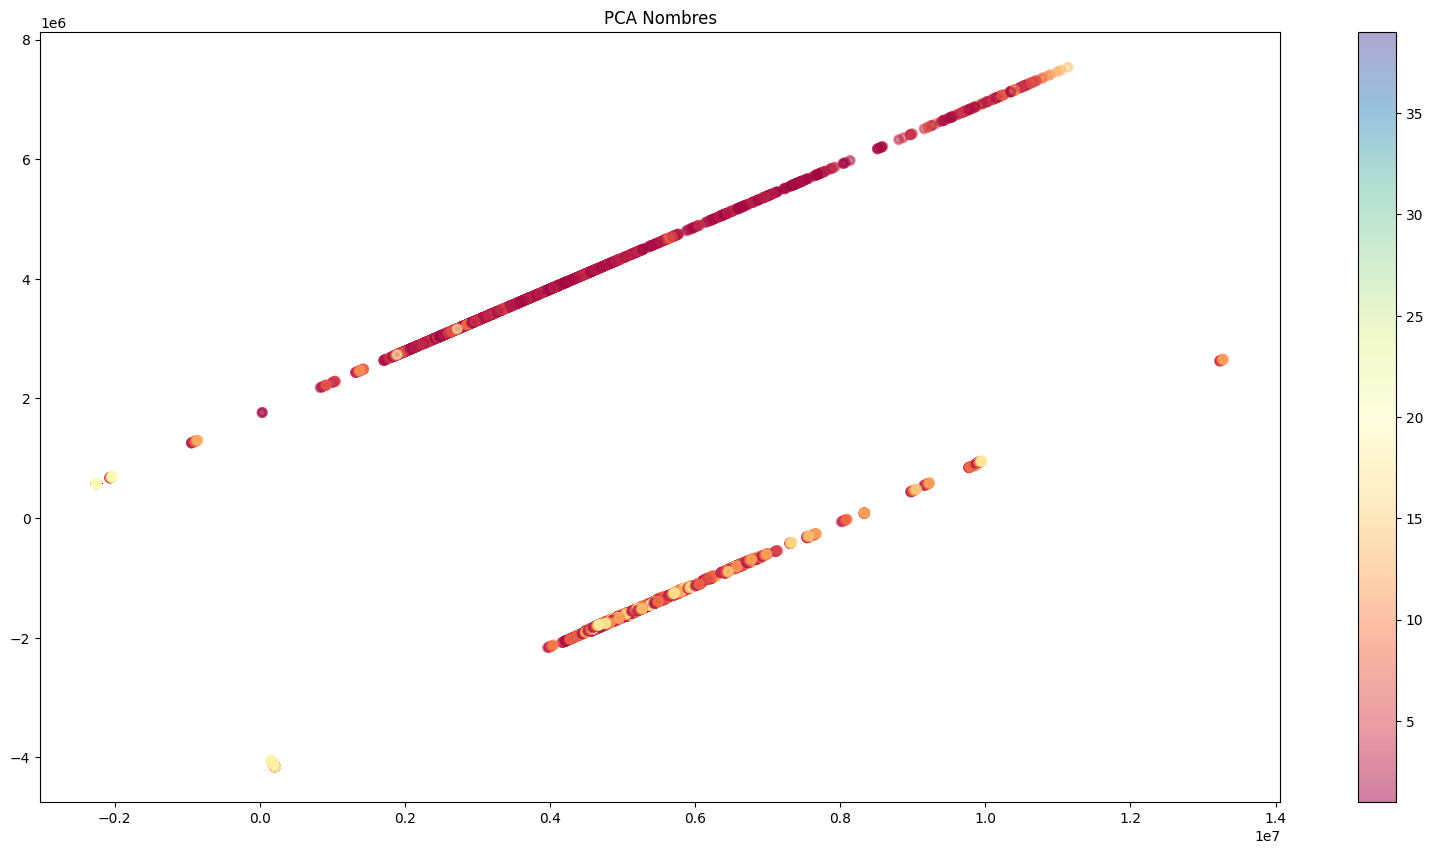

In [38]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(features_df)

plt.figure(1, figsize=(20, 10))
plt.scatter(
    x_pca[:, 0], x_pca[:, 1], c=target_df, alpha=0.5, lw=2, cmap="Spectral"
)

plt.title("PCA Nombres")
plt.colorbar()

## 4. UMAP
### 4.1. Clusterisation

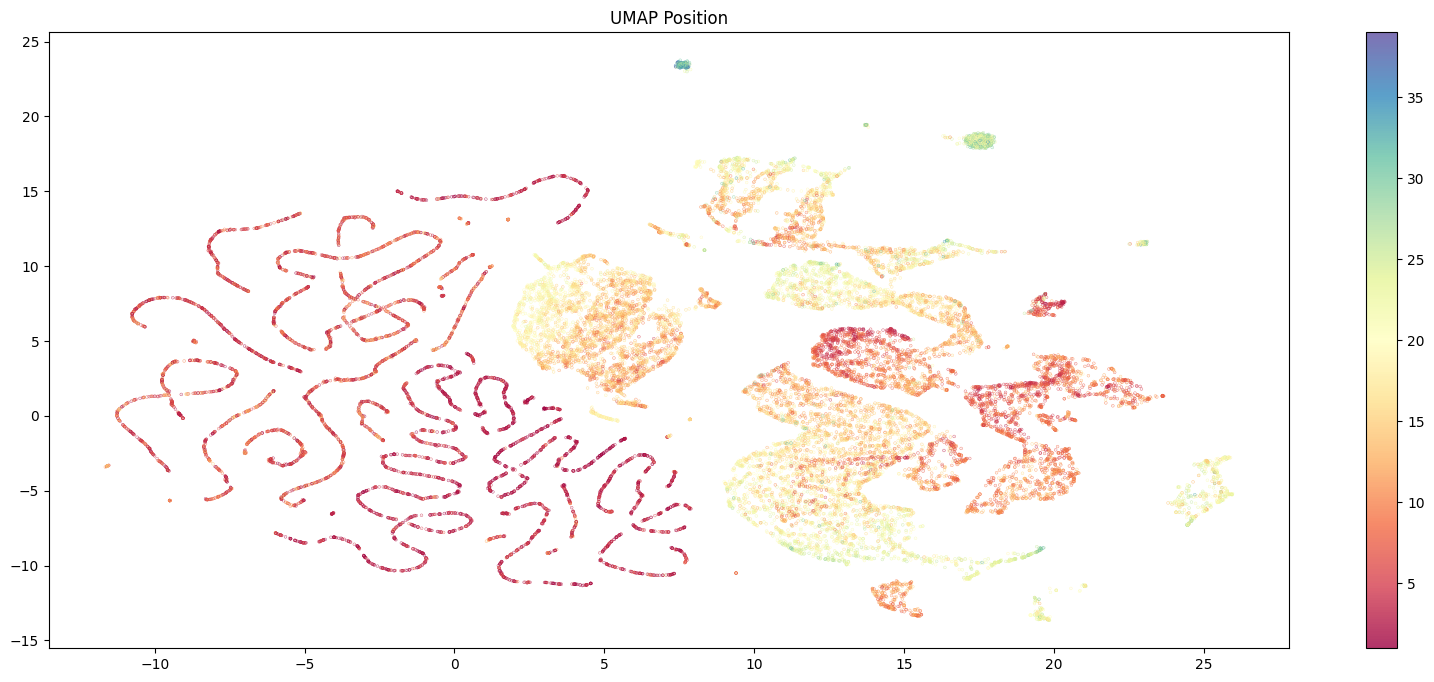

In [34]:
reducer = UMAP(n_components=2, min_dist=0.3, metric='correlation', n_jobs=-1, verbose=False, n_neighbors=18)
embedding = reducer.fit_transform(features_df)

plt.figure(1, figsize=(20, 8))
plt.scatter(
    embedding[:, 0], embedding[:, 1], s=0.1, c=target_df, alpha=0.8, lw=2, cmap="Spectral"
)

plt.title("UMAP Position")
plt.colorbar()

Dans cette figure une remarque que tous les rangs ne sont pas représenté deja, mais aussi nous avons certaines position qui sont dominantes (Maximum 3 sur plus de 28 positions de courses)

### 4.2. Calcul du score

In [35]:
def umap_dim_score():
    my_umap = UMAP(n_components=2, min_dist=0.3, metric='correlation', n_jobs=-1, verbose=False, n_neighbors=18)
    x_train_low = my_umap.fit_transform(X_train)
    x_test_low = my_umap.transform(X_test)
    kmeans = KMeans(n_clusters=25, random_state=0, n_init="auto").fit(x_train_low)
    y_pred = pd.Categorical(kmeans.predict(x_test_low))
    return f1_score(y_test, y_pred, average='macro')

score_low_dim = [umap_dim_score() for _ in range(10)]
print(f"Moyenne du score : {np.mean(score_low_dim):.4f}")
print(f"Ecart-type du score : {np.std(score_low_dim):.4f}")

/Users/stephcyrille/Projects/Personal/project_ia_f1_gp_predictor/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/stephcyrille/Projects/Personal/project_ia_f1_gp_predictor/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/stephcyrille/Projects/Personal/project_ia_f1_gp_predictor/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/stephcyrille/Projects/Personal/project_ia_f1_gp_predictor/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the spar

Moyenne du score : 0.0201
Ecart-type du score : 0.0034


La valeur du score confirme bien l'observation faite dans la section précédante. dans les prochaines notebooks nous allons poursuivre avec un modèle de classification supervisé et évaluer si les performances sont meilleures.